[ここな](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data)<br>
こっからデータとれ

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
# download https://teratail.com/questions/14124

In [69]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [70]:
df_droped = df.drop(['Province/State', 'Lat', 'Long'],axis = 1)
# lat, long 緯度と経度だね

In [75]:
df_droped.shape

(272, 363)

In [76]:
df_T = df_droped.groupby('Country/Region').agg(sum).T

In [94]:
mostcovid = df_T.sort_values('1/17/21',axis = 1, ascending = False).iloc[:, :10]

In [95]:
# pivoted_df = pd.pivot_table(df_droped, columns = 'Country/Region', aggfunc =sum)

In [96]:
plt.style.use('dark_background')

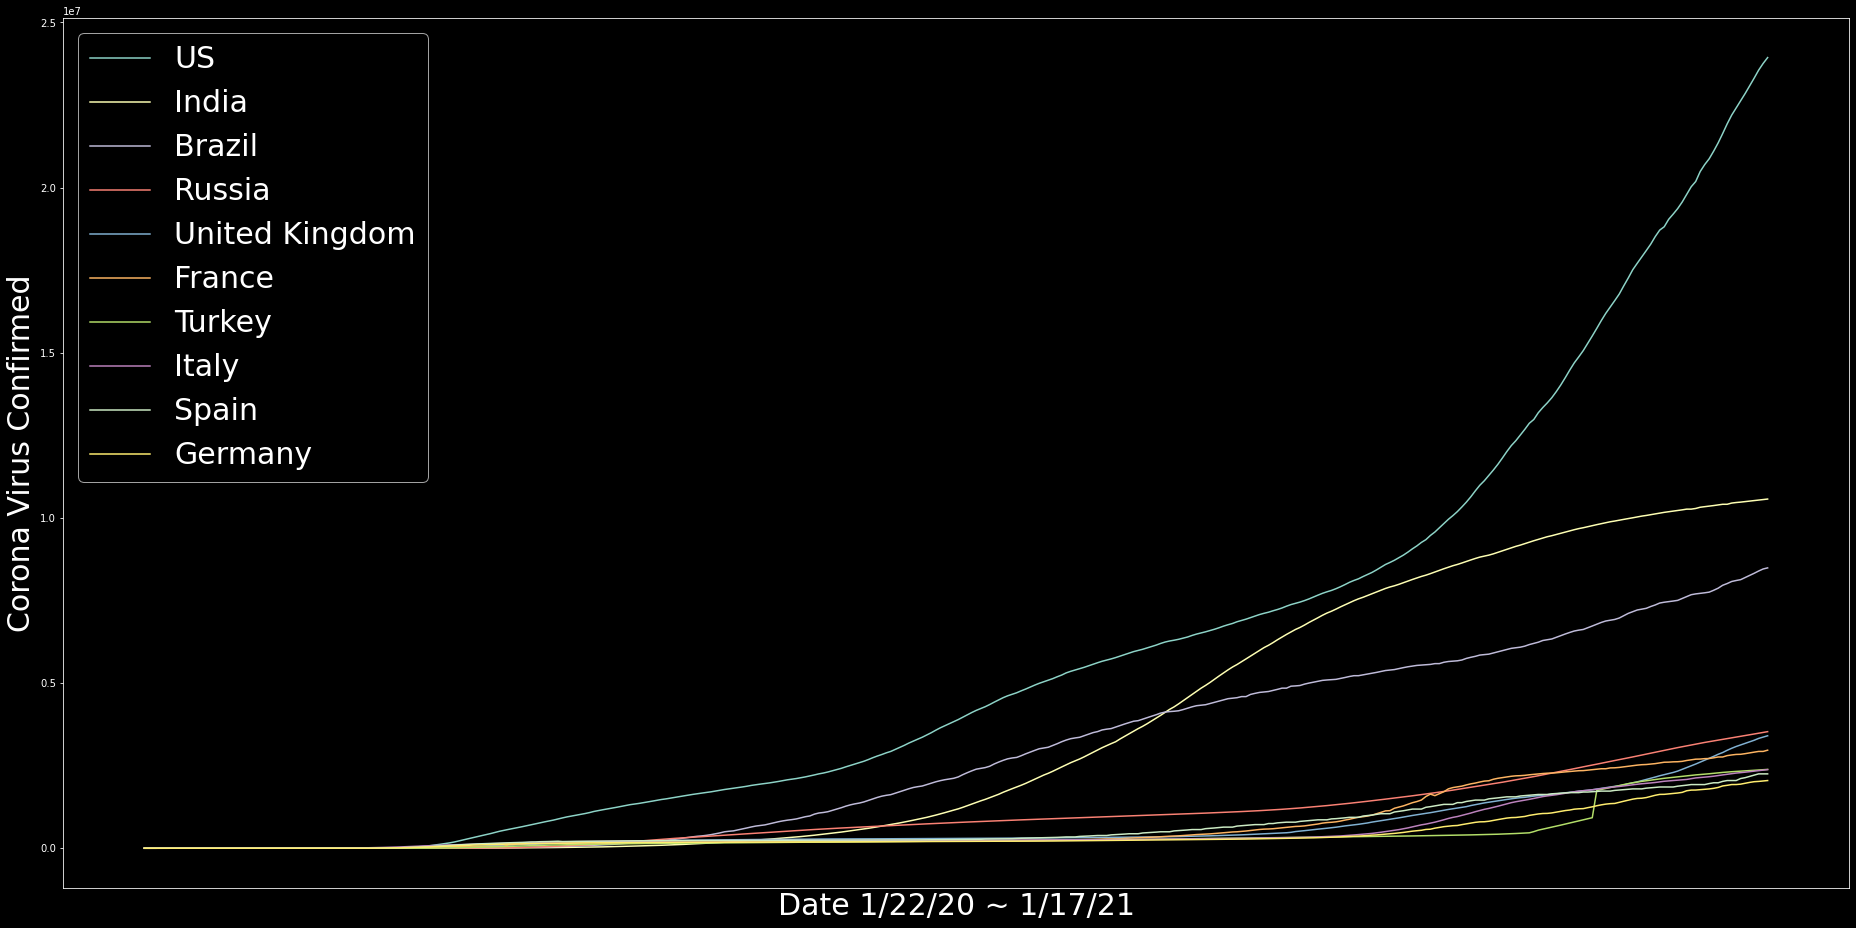

In [97]:
plt.figure(figsize=(32,16))
plt.plot(mostcovid)
plt.xlabel('Date 1/22/20 ~ 1/17/21', fontsize = 30)
plt.ylabel('Corona Virus Confirmed', fontsize = 30)
plt.xticks([])
plt.legend(mostcovid.columns,loc = "upper left", fontsize = 30)
plt.show()

In [98]:
JAPAN = df_T[['Japan']]

In [131]:
JAPAN.shape

(362, 1)

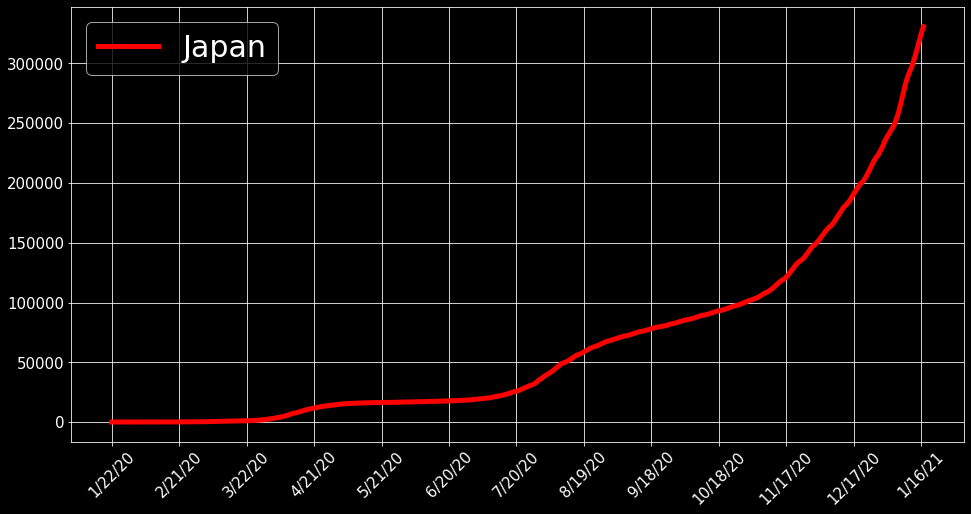

In [130]:
plt.figure(figsize=(16,8))
plt.plot(JAPAN, 'r-',lw = 5,)
# frequency
# https://stackoverflow.com/questions/41598935/choose-matplotlib-xticks-frequency
freq = 30
plt.xticks(JAPAN.index[::freq], rotation = 45, fontsize = 15)
plt.yticks(fontsize=15)
plt.legend(['Japan'],fontsize=30)
plt.grid(True)
plt.show()


# cumulative daily cases なので... 普通に日ごとに見てみよう

In [135]:
jap_daily = JAPAN.diff().fillna(0).astype(np.int32)
# diff が凄い

In [137]:
jap_daily.head(5)

Country/Region,Japan
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,2


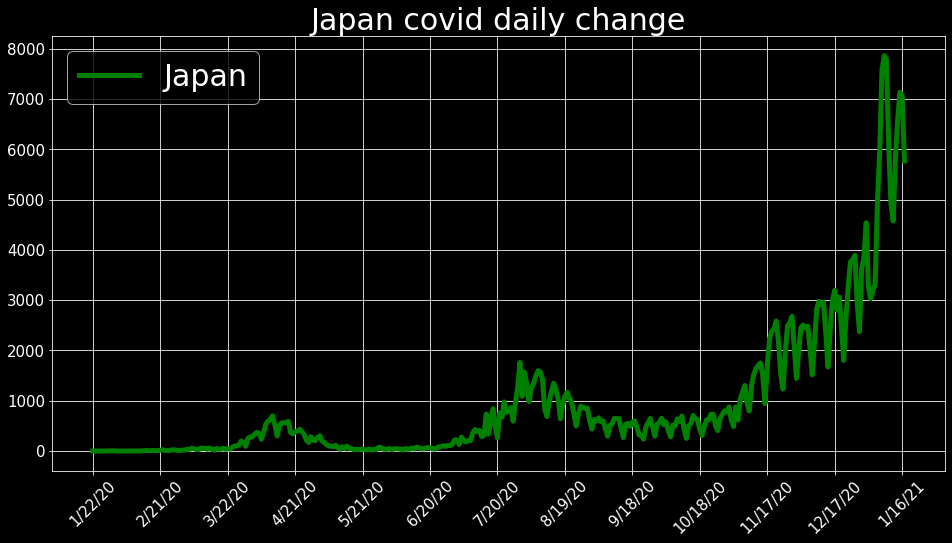

In [143]:
plt.figure(figsize=(16,8))
plt.plot(jap_daily, 'g-',lw = 5,)
# frequency
# https://stackoverflow.com/questions/41598935/choose-matplotlib-xticks-frequency
freq = 30
plt.xticks(JAPAN.index[::freq], rotation = 45, fontsize = 15)
plt.yticks(fontsize=15)
plt.legend(['Japan'],fontsize=30)
plt.grid(True)
plt.title('Japan covid daily change', fontsize = 30)
plt.show()

In [746]:
jap_daily.shape

(362, 1)

In [747]:
train_len = int(jap_daily.shape[0] * 0.96)
train_data = jap_daily[:train_len]
test_data = jap_daily[train_len:]

In [748]:
train_data.shape

(347, 1)

In [749]:
test_data.shape

(15, 1)

In [750]:
from sklearn.preprocessing import MinMaxScaler

In [751]:
scaler = MinMaxScaler()
scaled_tr = scaler.fit_transform(train_data)
scaled_te = scaler.fit_transform(test_data)

In [752]:
def sliding_windows(data, seq_length):
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i+seq_length)]
        y = data[(i+seq_length)] # leading
        xs.append(x)
        ys.append(y)
    # 1日ずつ取り出している
    return np.array(xs), np.array(ys)

In [753]:
seq_length = 3

X_train, y_train = sliding_windows(scaled_tr, seq_length)
X_test, y_test = sliding_windows(scaled_te, seq_length)

In [754]:
print(X_train.shape, y_train.shape)

(343, 3, 1) (343, 1)


In [755]:
print(X_test.shape, y_test.shape)

(11, 3, 1) (11, 1)


In [756]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [757]:
import torch.nn as nn
import torch.optim as optim
import tqdm

In [758]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, num_layers = 3):
        super(CoronaVirusPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = self.input_dim,
            hidden_size = self.hidden_dim,
            num_layers = self.num_layers,
            dropout = 0.1
        )
        
        self.linear = nn.Linear(in_features = hidden_dim, out_features = 1)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.seq_length, self.hidden_dim),
            torch.zeros(self.num_layers, self.seq_length, self.hidden_dim),
        )
    
    def forward(self, input):
        lstm_out, _ = self.lstm(
            input.view(len(input), self.seq_length, -1), # reshapeと一緒だよ
            self.hidden,
        )
        y_pred = self.linear(
            lstm_out.view(self.seq_length, len(input), self.hidden_dim)[-1],
        )
        return y_pred

In [759]:
def train_model(model, train_data, train_labels, test_data = None, test_labels = None):
    loss_fn = nn.MSELoss(reduction = 'sum')
    optimizer = optim.Adam(model.parameters(), lr = 0.005)
    
    num_epochs = 11
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        #print(X_train.shape)
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
                #print(X_test.shape, y_test.shape)
            test_hist[t] = test_loss.item()

            if t%5 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t%5 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
    return model.eval(), train_hist, test_hist

In [760]:
model = CoronaVirusPredictor(1, 64, seq_length = seq_length, num_layers = 2)

In [761]:
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 19.273590087890625 test loss: 5.793405532836914
Epoch 5 train loss: 11.943875312805176 test loss: 3.9623589515686035
Epoch 10 train loss: 9.577115058898926 test loss: 3.090399980545044


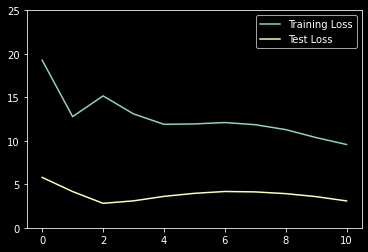

In [762]:
plt.plot(train_hist, label = 'Training Loss')
plt.plot(test_hist, label = 'Test Loss')
plt.ylim((0, 25))
plt.legend()

## ここをオリジナルとは改変を加えた場所
<br>予測したい値の前のデータを用いることで、関連性を加えて予測することが出来る。
<br>何気にぐにゃぐにゃしてるから予測出来てるかも！？


In [763]:
model.eval()
with torch.no_grad():
    # test_seq = X_train[-seq_length:]
    test_seq = X_train[-seq_length-X_test.shape[0]-1:]
    print(test_seq.shape)
    # print(test_seq.shape)
    # torch.Size([10, 10, 1])
    preds = []
    for _ in range(X_test.shape[0] + seq_length + 1):
        #print(test_seq)
        y_test_pred = model(test_seq)
        #print(y_test_pred.shape)
        pred = torch.flatten(y_test_pred[-1]).item()
        preds.append(pred)
        
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #print(new_seq.shape)
        test_seq = torch.as_tensor(new_seq).view(y_test_pred.shape[0], seq_length, 1).float()

torch.Size([15, 3, 1])


In [764]:
# true_data = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
predict = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

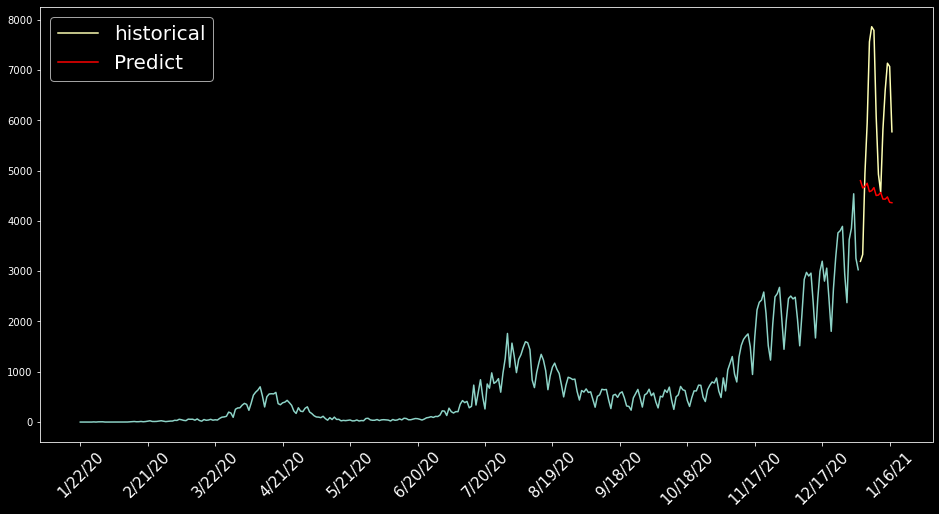

In [765]:
plt.figure(figsize = (16,8))
plt.plot(jap_daily[:train_len])
plt.plot(jap_daily[train_len:], label = 'historical')
plt.plot(jap_daily.index[train_len:], predict, 'r', label = 'Predict')
freq = 30
plt.xticks(jap_daily.index[::freq], fontsize = 15, rotation = 45)
plt.legend(fontsize = 20)
plt.show()